# Notebook to Investigate LSTM Performance Variance for Maritime Only Single Snow Type Model 

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.viz import download_metrics as dm
from snowML.datapipe.utils import snow_types as st
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import data_utils as du
from snowML.datapipe.utils import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
run_dict = {} 
run_dict["mar_custom_stop"] = "a45949b604bf47648c94faec3afee9ac"
run_dict["mar_mse_stop"] = "ef60ab19d7d6439caf2900baae7a0f5a"
run_dict["mar_cust_stop_95"] = "44f8fde0564e4f3da333a9d2ac948275"
run_dict["mar_cust_stop_95_redo"] = "d99e141d8e434b6fbfe57a8501736b35"
run_dict["mar_mse_stop_95"] = "4413fed5054540b8b26f3ca18fd7697a"
run_dict["mar_mse_stop_97"] = "cd60cfa3082c45108e84fd0c1a8fa972"

run_dict

{'mar_custom_stop': 'a45949b604bf47648c94faec3afee9ac',
 'mar_mse_stop': 'ef60ab19d7d6439caf2900baae7a0f5a',
 'mar_cust_stop_95': '44f8fde0564e4f3da333a9d2ac948275',
 'mar_cust_stop_95_redo': 'd99e141d8e434b6fbfe57a8501736b35',
 'mar_mse_stop_95': '4413fed5054540b8b26f3ca18fd7697a',
 'mar_mse_stop_97': 'cd60cfa3082c45108e84fd0c1a8fa972'}

In [4]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics


In [5]:
# display example
key = "mar_mse_stop_95"
df_metrics = df_dict[key]
print(df_metrics.shape)
df_metrics.head(2)


(4368, 3)


,Metric,Step,Value
0,test_kge_170200090101,0,0.841946
1,test_kge_170200090101,1,0.172166


# Step 2 - Functions to Summarize Metrics 

In [6]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [7]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

In [8]:
# function to extract only the last epoch 
def filter_to_last_step_per_metric(df):
    """
    Filters the DataFrame to include only rows where 'step' is the maximum for each 'metric'.
    
    Parameters:
        df (pd.DataFrame): A DataFrame with columns 'metric', 'step', and 'value'.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only the last step for each metric.
    """
    return df[df["Step"] == df.groupby("Metric")["Step"].transform("max")]



Examples 

In [9]:
df_kge = extract_metric_by_prefix(df_metrics, "test_kge", step = True)
#df_kge[df_kge["Metric"] == "test_kge_171100051001"]
df_kge.head()

,Metric,Step,Value
0,test_kge_170200090101,0,0.841946
1,test_kge_170200090101,1,0.172166
2,test_kge_170200090101,2,0.707415
3,test_kge_170200090101,3,0.875503
4,test_kge_170200090101,4,0.810079


In [10]:
df_kge_last = filter_to_last_step_per_metric(df_kge)
df_kge_last.head()

,Metric,Step,Value
5,test_kge_170200090101,5,0.886747
93,test_kge_170200090102,2,0.965549
1776,test_kge_170200090103,1,0.926368
1798,test_kge_170200090104,0,0.923034
1887,test_kge_170200090105,2,0.961780


In [11]:
df_sorted = df_kge_last.sort_values("Value")
df_sorted.head()

,Metric,Step,Value
3646,test_kge_171100070106,9,0.378589
1628,test_kge_171100051004,9,0.466617
591,test_kge_171100051005,9,0.483673
2375,test_kge_171100090302,9,0.485923
3043,test_kge_171100090303,0,0.497462


In [12]:
df_kge_last.describe()

,Step,Value
count,154.000000,154.000000
mean,2.545455,0.836077
std,3.683723,0.115843
min,0.000000,0.378589
25%,0.000000,0.772499
50%,0.000000,0.870087
75%,3.750000,0.924065
max,9.000000,0.974426


# Step 3- Compare Runs

In [13]:
def assemble_summary(run_dict, metric_nm): 
    df_summary_dict = {}
    for key in run_dict.keys(): 
        df_metrics = df_dict[key]
        df_filtered = extract_metric_by_prefix(df_metrics, metric_nm, step=True)
        df_metric_last = filter_to_last_step_per_metric(df_filtered)

        # Set the index to the 'metric' column
        df_metric_last = df_metric_last.set_index("Metric")

        # Append the key to all other column names (except the index)
        df_metric_last = df_metric_last.add_suffix(f"_{key}")
        df_metric_last.columns = df_metric_last.columns.str.replace("Value", metric_nm)

        # Store in the summary dictionary
        df_summary_dict[key] = df_metric_last

    # Concatenate all DataFrames on the index (metric)
    df_summary = pd.concat(df_summary_dict.values(), axis=1)

    return df_summary


In [14]:
def slim_by_prefix(df, prefix):
    """
    Returns a new DataFrame containing only the columns whose names start with the given prefix.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): Column prefix to filter by (e.g., "Test_KGE").
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only matching columns.
    """
    slim_cols = [col for col in df.columns if col.startswith(prefix)]
    return df[slim_cols].copy()


In [15]:
df_summary = assemble_summary(run_dict, "test_kge")
df_summary.head()

,Step_mar_custom_stop,test_kge_mar_custom_stop,Step_mar_mse_stop,test_kge_mar_mse_stop,Step_mar_cust_stop_95,test_kge_mar_cust_stop_95,Step_mar_cust_stop_95_redo,test_kge_mar_cust_stop_95_redo,Step_mar_mse_stop_95,test_kge_mar_mse_stop_95,Step_mar_mse_stop_97,test_kge_mar_mse_stop_97
Metric,,,,,,,,,,,,
test_kge_170200090101,9,0.889561,2,0.927075,9,0.908979,9,0.841040,5,0.886747,9,0.800335
test_kge_170200090102,0,0.905767,2,0.880160,9,0.892814,9,0.896262,2,0.965549,1,0.925318
test_kge_170200090103,0,0.909725,0,0.919345,8,0.940412,6,0.935913,1,0.926368,0,0.957613
test_kge_170200090104,0,0.904171,0,0.943969,7,0.945578,4,0.960182,0,0.923034,4,0.908536
test_kge_170200090105,0,0.931730,0,0.942438,3,0.926124,0,0.963691,2,0.961780,3,0.919231


In [16]:
df_summary_slim = slim_by_prefix(df_summary, "test_kge")
df_summary_slim.describe()

,test_kge_mar_custom_stop,test_kge_mar_mse_stop,test_kge_mar_cust_stop_95,test_kge_mar_cust_stop_95_redo,test_kge_mar_mse_stop_95,test_kge_mar_mse_stop_97
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.821598,0.827834,0.835819,0.837490,0.836077,0.826830
std,0.111224,0.128229,0.121533,0.112699,0.115843,0.121522
min,0.379775,0.296953,0.340150,0.375142,0.378589,0.340008
25%,0.769904,0.780223,0.774380,0.781121,0.772499,0.760075
50%,0.849167,0.858938,0.869900,0.869673,0.870087,0.866738
75%,0.900786,0.923750,0.926905,0.924145,0.924065,0.926656
max,0.961681,0.976607,0.974814,0.982715,0.974426,0.970454


# Step 4 - Plot 

In [17]:
def plot_metric_boxplots(df, prefix="test_kGE"):
    """
    Plots boxplots for all columns in the DataFrame that start with the given prefix.
    Uses the remainder of the column name (after the prefix + underscore) as the label.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): The prefix to filter columns by (e.g., 'Test_KGE', 'Test_MSE').
    """
    # Ensure prefix ends with "_" for clean suffix extraction
    prefix = prefix.rstrip("_") + "_"

    # Filter relevant columns
    metric_cols = [col for col in df.columns if col.startswith(prefix)]

    if not metric_cols:
        print(f"No columns found with prefix '{prefix}'")
        return

    # Reshape to long format
    df_long = df[metric_cols].copy()
    df_long = df_long.melt(var_name="Metric", value_name="Value")

    # Clean up the Metric labels
    df_long["Metric"] = df_long["Metric"].str.replace(prefix, "", regex=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_long, x="Metric", y="Value")
    plt.xticks(rotation=45)
    plt.title(f"{prefix.strip('_')} by Strategy")
    plt.tight_layout()
    plt.show()


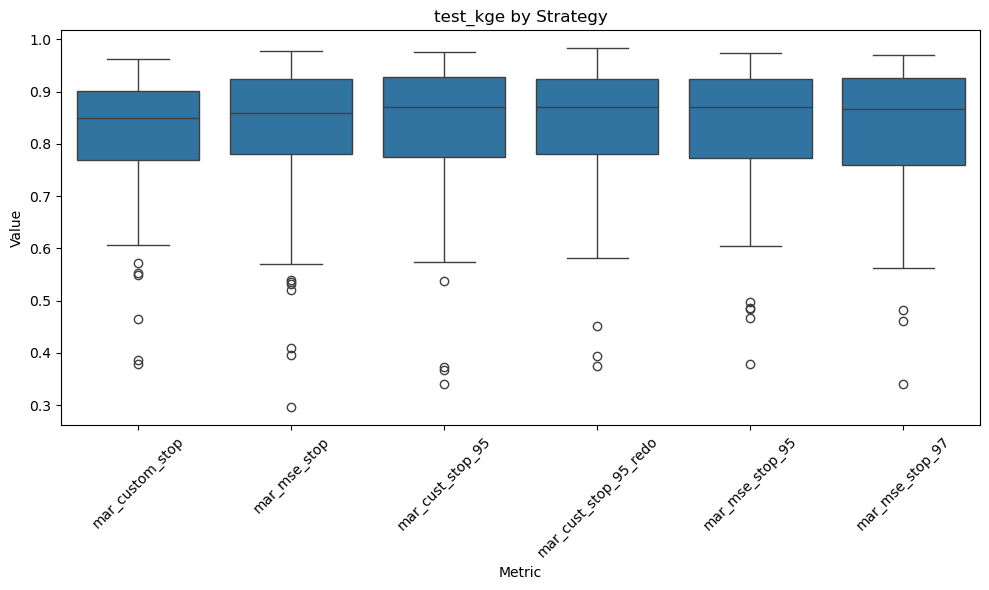

In [18]:
plot_metric_boxplots(df_summary, prefix="test_kge")

# Step 5 Compare to Results By Epoch No_stop Run 

In [19]:
run_dict_no_stop = {}
run_dict_no_stop["Mar_custom"] = "c05b6e79957b4530967b4b050c32e569"
run_dict_no_stop["Mar_mse"] = "753f3cb9fe584239959a64610d50bae8"

In [20]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict_no_stop = {}
for key in run_dict_no_stop.keys(): 
    run_id = run_dict_no_stop[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict_no_stop[key] = df_metrics

In [21]:
key = "Mar_mse"
metric_nm = "test_kge"
df_metrics = df_dict_no_stop[key]
df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
df_epoch_0 =  df_filtered[df_filtered["Step"] == 0]
# Set the index to the 'metric' column
df_epoch_0 = df_epoch_0.set_index("Metric")
# Append the key to all other column names (except the index)
df_epoch_0 = df_epoch_0.add_suffix(f"_{key}")
df_epoch_0.columns = df_epoch_0.columns.str.replace("Value", metric_nm)
df_epoch_0.head()

# Concatenate all DataFrames on the index (metric)
df_summary_all = pd.concat([df_summary, df_epoch_0], axis=1)
df_summary_all.head()



,Step_mar_custom_stop,test_kge_mar_custom_stop,Step_mar_mse_stop,test_kge_mar_mse_stop,Step_mar_cust_stop_95,test_kge_mar_cust_stop_95,Step_mar_cust_stop_95_redo,test_kge_mar_cust_stop_95_redo,Step_mar_mse_stop_95,test_kge_mar_mse_stop_95,Step_mar_mse_stop_97,test_kge_mar_mse_stop_97,Step_Mar_mse,test_kge_Mar_mse
Metric,,,,,,,,,,,,,,
test_kge_170200090101,9,0.889561,2,0.927075,9,0.908979,9,0.841040,5,0.886747,9,0.800335,0,0.022416
test_kge_170200090102,0,0.905767,2,0.880160,9,0.892814,9,0.896262,2,0.965549,1,0.925318,0,0.853573
test_kge_170200090103,0,0.909725,0,0.919345,8,0.940412,6,0.935913,1,0.926368,0,0.957613,0,0.869361
test_kge_170200090104,0,0.904171,0,0.943969,7,0.945578,4,0.960182,0,0.923034,4,0.908536,0,0.945644
test_kge_170200090105,0,0.931730,0,0.942438,3,0.926124,0,0.963691,2,0.961780,3,0.919231,0,0.975387


In [22]:
df_summary_all_slim = slim_by_prefix(df_summary_all, "test_kge")
df_summary_all_slim.describe()


,test_kge_mar_custom_stop,test_kge_mar_mse_stop,test_kge_mar_cust_stop_95,test_kge_mar_cust_stop_95_redo,test_kge_mar_mse_stop_95,test_kge_mar_mse_stop_97,test_kge_Mar_mse
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.821598,0.827834,0.835819,0.837490,0.836077,0.826830,0.795753
std,0.111224,0.128229,0.121533,0.112699,0.115843,0.121522,0.198543
min,0.379775,0.296953,0.340150,0.375142,0.378589,0.340008,-0.706857
25%,0.769904,0.780223,0.774380,0.781121,0.772499,0.760075,0.729029
50%,0.849167,0.858938,0.869900,0.869673,0.870087,0.866738,0.867819
75%,0.900786,0.923750,0.926905,0.924145,0.924065,0.926656,0.917931
max,0.961681,0.976607,0.974814,0.982715,0.974426,0.970454,0.975387


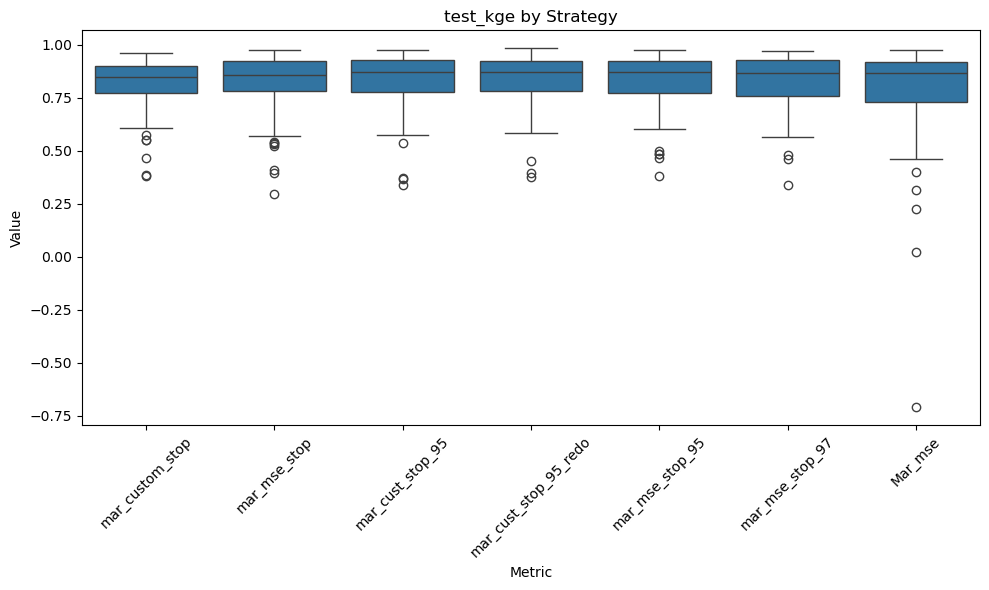

In [23]:
plot_metric_boxplots(df_summary_all, prefix="test_kge")